<a href="https://colab.research.google.com/github/AbdoAlkayal/ML-DL-projects/blob/main/Classification(using_pretrained_model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [ ]:
# Load Dataset
print("Loading Dataset...")
(train_data, test_data), info = tfds.load('stanford_dogs', split=['train', 'test'], shuffle_files=True, with_info=True, as_supervised=True)
print("Dataset Loaded")
print("Number of training examples:", info.splits['train'].num_examples)
print("Number of test examples:", info.splits['test'].num_examples)
print("Number of classes:", info.features['label'].num_classes)
print("Class names:", info.features['label'].names)

Loading Dataset...
Dataset Loaded
Number of training examples: 12000
Number of test examples: 8580
Number of classes: 120
Class names: ['n02085620-chihuahua', 'n02085782-japanese_spaniel', 'n02085936-maltese_dog', 'n02086079-pekinese', 'n02086240-shih-tzu', 'n02086646-blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-rhodesian_ridgeback', 'n02088094-afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-walker_hound', 'n02089973-english_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-irish_wolfhound', 'n02091032-italian_greyhound', 'n02091134-whippet', 'n02091244-ibizan_hound', 'n02091467-norwegian_elkhound', 'n02091635-otterhound', 'n02091831-saluki', 'n02092002-scottish_deerhound', 'n02092339-weimaraner', 'n02093256-staffordshire_bullterrier', 'n02093428-american_staffordshire_terrier', 'n02093647-bedlington_terrier', 'n02093754-border_terrier', 'n02

In [ ]:
train_data=tfds.load('stanford_dogs', split='train[:90%]', as_supervised=True)
val_data=tfds.load('stanford_dogs', split='train[90%:]', as_supervised=True)

print("Number of training examples:", len(list(train_data)))
print("Number of validation examples:", len(list(val_data)))

Number of training examples: 10800
Number of validation examples: 1200


In [ ]:
data_augmentation_layer = tf.keras.Sequential([
    layers.Resizing(256, 256),              # Fixed size before augmenting
    layers.RandomCrop(224, 224),            # Crop to model size
    layers.RandomFlip('horizontal'),
    layers.RandomFlip('vertical')
])

In [ ]:
# Preprocessing functions
def preprocessing(image, label):
    image = tf.image.resize(image, [224, 224])
    return image, label

def preprocessing_augmentation(image, label):
    image = tf.cast(image, tf.float32)
    image = data_augmentation_layer(image)
    image = preprocess_input(image)
    return image, label

In [ ]:
# Prepare datasets
print("\nPreparing datasets...")
original_train = train_data.map(preprocessing).shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)
val = val_data.map(preprocessing).batch(16).prefetch(tf.data.AUTOTUNE)
test = test_data.map(preprocessing).batch(16).prefetch(tf.data.AUTOTUNE)
augmented_train = train_data.map(preprocessing_augmentation).shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)
print("Datasets ready.")


Preparing datasets...
Datasets ready.


In [ ]:
# Build model
def building_model():
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='sigmoid'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(120, activation='softmax')  # 120 classes in Stanford Dogs
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Early stopping
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
with tf.device('/GPU:0'):
    # Train without data augmentation
    print("\nTraining model without data augmentation...")
    without_data_augmentation = building_model()
    history_without_data_augmentation = without_data_augmentation.fit(original_train, epochs=10, validation_data=val, callbacks=[earlyStopping])
    print("Training without augmentation complete.")


Training model without data augmentation...
Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 63s 69ms/step - accuracy: 0.1049 - loss: 4.1650 - val_accuracy: 0.3758 - val_loss: 2.2183
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.4561 - loss: 1.9484 - val_accuracy: 0.4850 - val_loss: 1.7185
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.5695 - loss: 1.4774 - val_accuracy: 0.5308 - val_loss: 1.6218
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.6391 - loss: 1.2223 - val_accuracy: 0.5367 - val_loss: 1.5771
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.6851 - loss: 1.0304 - val_accuracy: 0.5533 - val_loss: 1.5129
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.7335 - loss: 0.8740 - val_accuracy: 0.5542 - val_loss: 1.5163
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.7626 - loss: 0.7618 - val_accuracy: 0.5508 - val_loss: 1.5669
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 39s 5

In [ ]:
# Train with data augmentation
print("\nTraining model with data augmentation...")
with_data_augmentation = building_model()
history_with_data_augmentation = with_data_augmentation.fit(augmented_train, epochs=10, validation_data=val, callbacks=[earlyStopping])
print("Training with augmentation complete.")


Training model with data augmentation...
Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 128s 163ms/step - accuracy: 0.1394 - loss: 3.9767 - val_accuracy: 0.2600 - val_loss: 2.9669
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 117s 162ms/step - accuracy: 0.5134 - loss: 1.7598 - val_accuracy: 0.3108 - val_loss: 2.6806
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 113s 157ms/step - accuracy: 0.5855 - loss: 1.4339 - val_accuracy: 0.3092 - val_loss: 2.8853
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 113s 158ms/step - accuracy: 0.6258 - loss: 1.2791 - val_accuracy: 0.3217 - val_loss: 2.9013
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 111s 155ms/step - accuracy: 0.6504 - loss: 1.1703 - val_accuracy: 0.3458 - val_loss: 2.8497
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 142s 154ms/step - accuracy: 0.6630 - loss: 1.1203 - val_accuracy: 0.3500 - val_loss: 2.9285
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 111s 154ms/step - accuracy: 0.6720 - loss: 1.0800 - val_accuracy: 0.3458 - val_loss: 2.9148
Training with augmentation complet

In [ ]:
# Evaluate models
print("\nEvaluating both models on test set...")
loss_without_data_augmentation, accuracy_without_data_augmentation = without_data_augmentation.evaluate(test)
loss_with_data_augmentation, accuracy_with_data_augmentation = with_data_augmentation.evaluate(test)


Evaluating both models on test set...
537/537 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - accuracy: 0.5680 - loss: 1.5208
537/537 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.3343 - loss: 2.6615


In [ ]:
# Print results
print("\n Evaluation Results")
print(f"Model WITHOUT Augmentation -> Accuracy: {accuracy_without_data_augmentation:.4f}, Loss: {loss_without_data_augmentation:.4f}")
print(f"Model WITH Augmentation    -> Accuracy: {accuracy_with_data_augmentation:.4f}, Loss: {loss_with_data_augmentation:.4f}")


 Evaluation Results
Model WITHOUT Augmentation -> Accuracy: 0.5710, Loss: 1.5165
Model WITH Augmentation    -> Accuracy: 0.3302, Loss: 2.6934


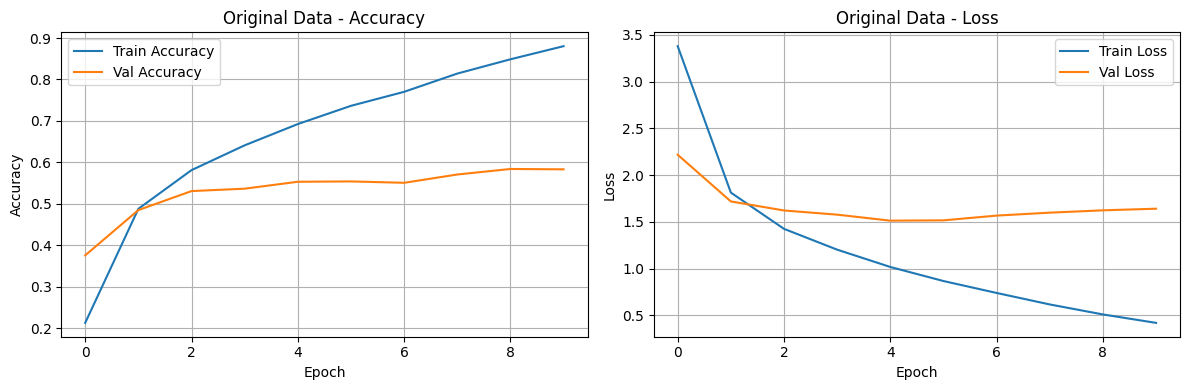


Original Data Final Metrics:
Train Accuracy: 0.8804
Val Accuracy:   0.5833
Train Loss:     0.4190
Val Loss:       1.6408


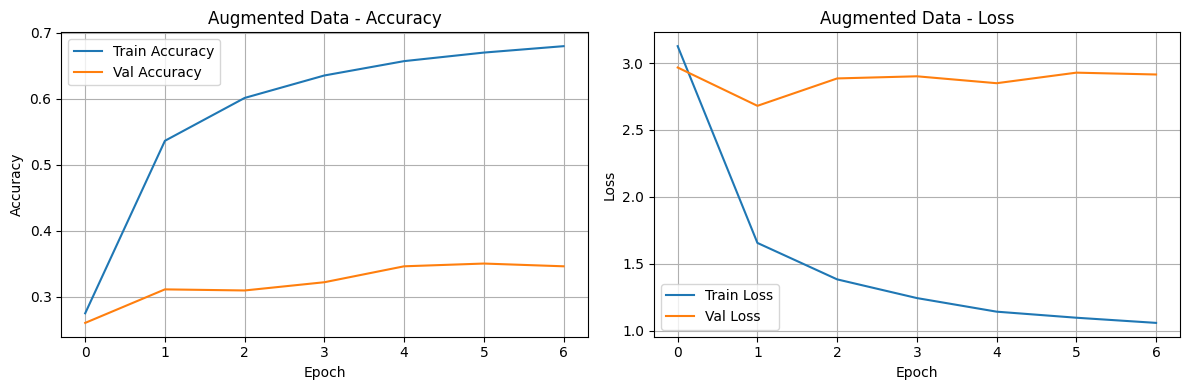


Augmented Data Final Metrics:
Train Accuracy: 0.6797
Val Accuracy:   0.3458
Train Loss:     1.0579
Val Loss:       2.9148


In [ ]:
# Plot and print training history with loss and accuracy
def plot_history(hist, title):
    # Plot Accuracy
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print(f"\n{title} Final Metrics:")
    print(f"Train Accuracy: {hist.history['accuracy'][-1]:.4f}")
    print(f"Val Accuracy:   {hist.history['val_accuracy'][-1]:.4f}")
    print(f"Train Loss:     {hist.history['loss'][-1]:.4f}")
    print(f"Val Loss:       {hist.history['val_loss'][-1]:.4f}")

# Call the function for both models
plot_history(history_without_data_augmentation, "Original Data")
plot_history(history_with_data_augmentation, "Augmented Data")


In [ ]:
# Get final epoch values
final_train_loss_no_aug = history_without_data_augmentation.history['loss'][-1]
final_train_acc_no_aug = history_without_data_augmentation.history['accuracy'][-1]
final_val_loss_no_aug = history_without_data_augmentation.history['val_loss'][-1]
final_val_acc_no_aug = history_without_data_augmentation.history['val_accuracy'][-1]

final_train_loss_aug = history_with_data_augmentation.history['loss'][-1]
final_train_acc_aug = history_with_data_augmentation.history['accuracy'][-1]
final_val_loss_aug = history_with_data_augmentation.history['val_loss'][-1]
final_val_acc_aug = history_with_data_augmentation.history['val_accuracy'][-1]


# Create a DataFrame for clean display
results_df = pd.DataFrame({
    'Model': ['Pretrained_no_aug', 'Pretrained_aug'],
    'Train Loss': [final_train_loss_no_aug, final_train_loss_aug],
    'Train Accuracy': [final_train_acc_no_aug, final_train_acc_aug],
    'Validation Loss': [final_val_loss_no_aug, final_val_loss_aug],
    'Validation Accuracy': [final_val_acc_no_aug, final_val_acc_aug]
})

print("\n Final Results Summary ")
print(results_df.to_string(index=False))



 Final Results Summary 
            Model  Train Loss  Train Accuracy  Validation Loss  Validation Accuracy
Pretrained_no_aug    0.419040        0.880370         1.640831             0.583333
   Pretrained_aug    1.057857        0.679722         2.914801             0.345833
